In [2]:
import tensorflow as tf
from keras import backend as K
from keras.models import load_model

import os
import numpy as np
import sys
import matplotlib.pyplot as plt

sys.path.append(os.path.join(os.path.dirname('__file__'), "./src/"))
from utilFunctions import smooth_obs
from audio_preprocessing import getMFCCBands2DMadmom
from madmom.features.onsets import OnsetPeakPickingProcessor

Using TensorFlow backend.


In [1]:
def boundary_decoding(obs_i,
                      threshold,
                      hopsize_t,
                      OnsetPeakPickingProcessor):

    """decode boundary"""
    arg_pp = {'threshold': threshold,
              'smooth': 0,
              'fps': 1. / hopsize_t,
              'pre_max': hopsize_t,
              'post_max': hopsize_t}

    peak_picking = OnsetPeakPickingProcessor(**arg_pp)
    i_boundary = peak_picking.process(obs_i)
    i_boundary = np.append(i_boundary, (len(obs_i) - 1) * hopsize_t)
    i_boundary /= hopsize_t
    return i_boundary
def auc(y_true, y_pred):
    auc = tf.metrics.auc(y_true, y_pred)[1]
    K.get_session().run(tf.local_variables_initializer())
    return auc

import pickle

with open("training_data/scaler.pkl", "rb") as file:
    scaler = pickle.load(file)

In [3]:
my_model = load_model(os.path.join("models/" + 'trained_model.h5'), custom_objects={ 'auc': auc})

In [4]:
my_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 8, 78, 9)          176       
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 8, 76, 7)          584       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 8, 25, 7)          0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 8, 25, 7)          32        
_________________________________________________________________
dropout_3 (Dropout)          (None, 8, 25, 7)          0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 16, 24, 6)         528       
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 16, 23, 5)         1040      
__________

In [5]:
wav_jingju = 'wavs/a_rendezvous_with_sleep_paralysis.wav'
log_mel = scaler.transform(getMFCCBands2DMadmom(wav_jingju, 44100, 0.01, channel=1))

In [6]:
log_mel = log_mel.reshape(log_mel.shape[0], 80, 15)
log_mel = np.expand_dims(log_mel, axis=1)
pdf = my_model.predict(log_mel, batch_size = 256)
pdf = np.squeeze(pdf)
pdf = smooth_obs(pdf)

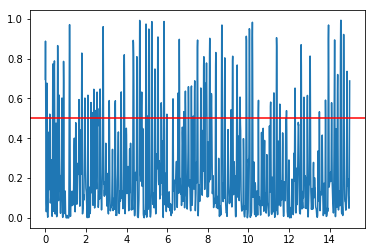

In [7]:
snip = pdf[0: 15*100]
x = np.arange(0, len(snip)) * 0.01
plt.plot(x, snip)
plt.axhline(y=0.5, color='r', linestyle='-')
plt.show()

In [15]:
b_baseline = boundary_decoding(obs_i=pdf,
                              threshold=0.5,
                              hopsize_t=0.01,
                              OnsetPeakPickingProcessor=OnsetPeakPickingProcessor)
b_baseline.shape

(595,)

In [13]:
lines = []
with open("timings/a_rendezvous_with_sleep_paralysis.txt", "r") as file:
    lines = file.readlines()
    lines = np.asarray([x.replace("\n", "").split(" ")[1] for x in lines[3:]]).astype("float")
lines.shape

(662,)

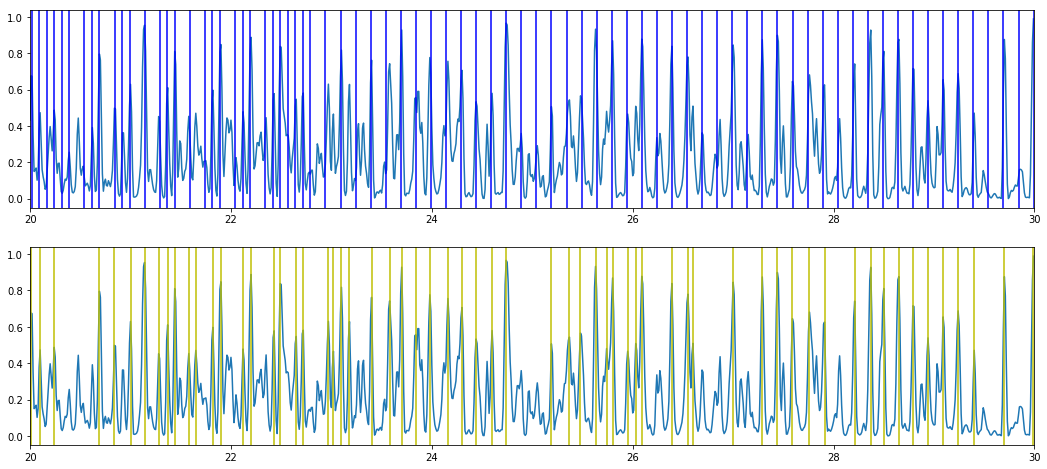

In [14]:
fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True)
fig.set_size_inches(18, 8)
start = 20
end = 30
snip = pdf[start * 100: end*100]
x = np.arange(start*100, end*100) * 0.01

ax1 = plt.subplot(211)
ax1.plot(x, snip)
#plt.axhline(y=0.5, color='r', linestyle='-')
for mark in lines:
    if mark < start:
        continue
    elif mark > end:
        break
    ax1.axvline(x=mark, color= 'b')
plt.xlim(start, end)
ax2 = plt.subplot(212)
ax2.plot(x, snip)
#plt.axhline(y=0.5, color='r', linestyle='-')
for mark in b_baseline*0.01:
    if mark < start:
        continue
    elif mark > end:
        break
    ax2.axvline(x=mark, color= 'y')
plt.xlim(start, end)
plt.show()